In [7]:
import open3d, os, sys, torch
import matplotlib.pyplot as plt

from pytorch3d.io import load_objs_as_meshes

from pytorch3d.renderer import (
look_at_view_transform,
PerspectiveCameras,
PointLights,
Materials,
RasterizationSettings,
MeshRenderer,
MeshRasterizer
)

from pytorch3d.renderer.mesh.shader import HardPhongShader

from pathlib import Path

sys.path.append(os.path.abspath(''))

## Загрузка модели

In [6]:
!curl https://raw.githubusercontent.com/PacktPublishing/3D-Deep-Learning-with-Python/refs/heads/main/chap2/data/cow_mesh/cow.mtl -o ./data/cow_mesh/cow.mtl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   155  100   155    0     0    294      0 --:--:-- --:--:-- --:--:--   295


In [10]:
DATA_DIR = Path("./data")
obj_filename = DATA_DIR / 'cow_mesh' / 'cow.obj'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [11]:
mesh = load_objs_as_meshes([obj_filename], device=device)

## Создание виртуальной среды

In [13]:
R, T = look_at_view_transform(2.7, 0, 180)
cameras = PerspectiveCameras(device = device, R=R, T=T)
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

In [14]:
raster_settings = RasterizationSettings(
    image_size=512,
    blur_radius=0.0,
    faces_per_pixel=1
)

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(
        device=device,
        cameras=cameras,
        lights=lights
    )
)

## Отрисовка

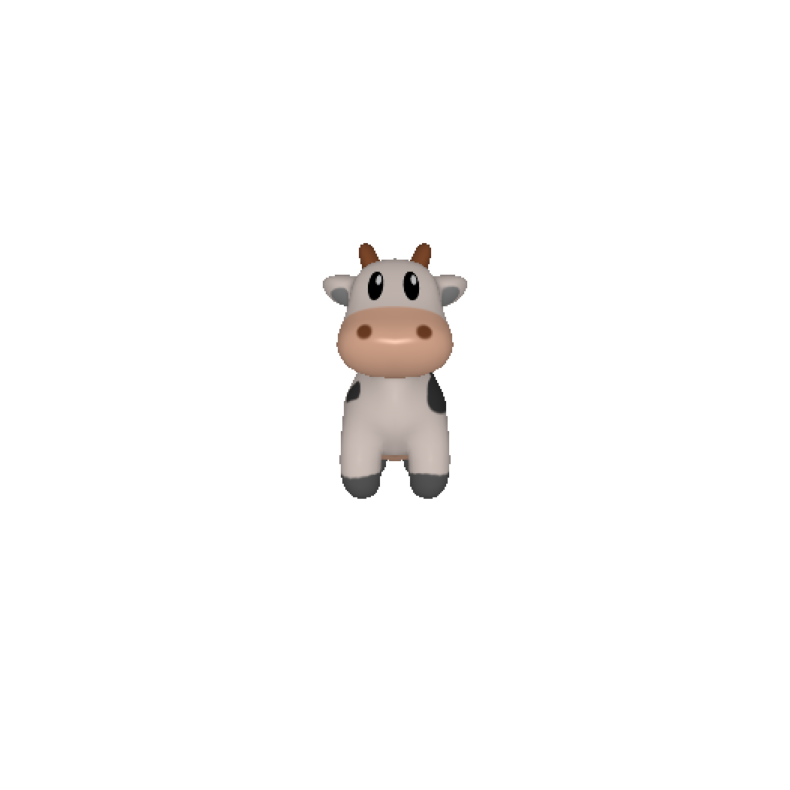

In [17]:
images = renderer(mesh)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis('off')
plt.savefig('light_at_front.png')
plt.show()

## Меняем локацию света

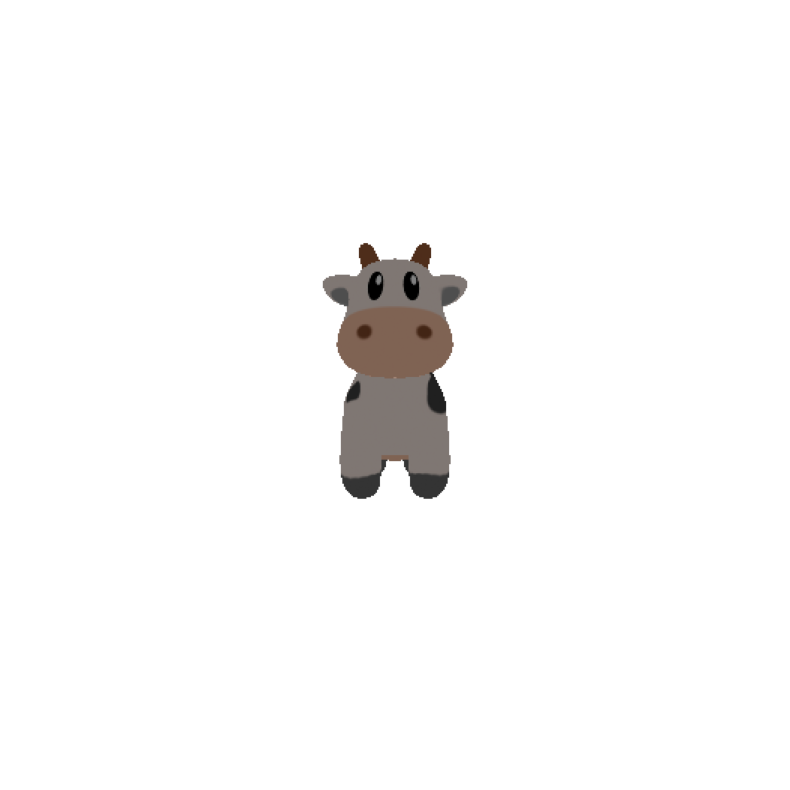

In [31]:
lights.location = torch.tensor([0.0, 0.0, +1.0], device=device).unsqueeze(0)
images = renderer(mesh)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis('off')
plt.savefig('light_at_back.png')
plt.show()

## Зададим зеркальный блеск

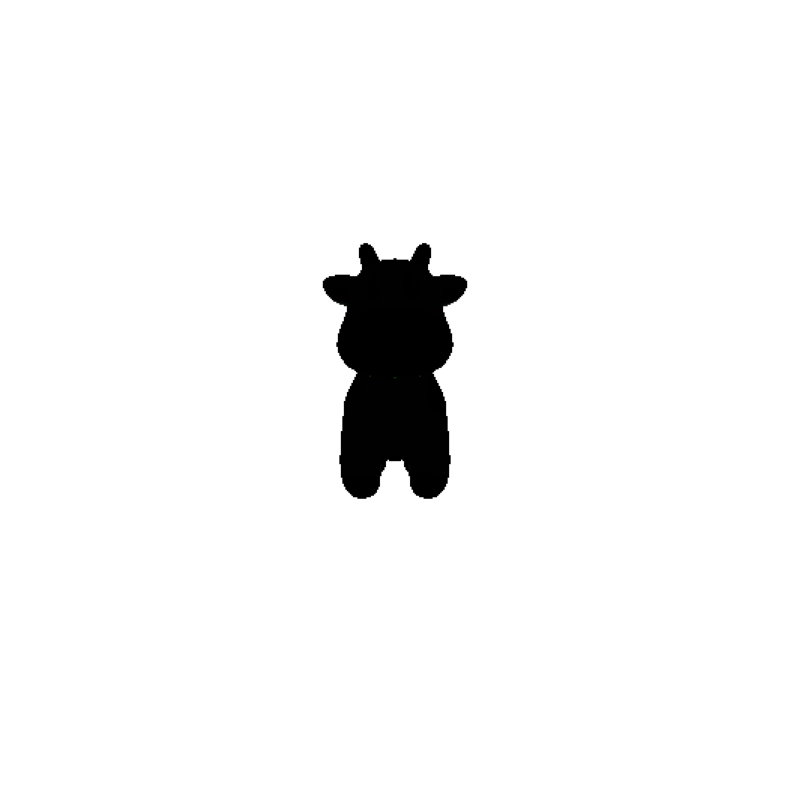

In [30]:
materials = Materials(
    device=device,
    specular_color=[[0.0, 1.0, 0.0]],
    shininess=10.0,
    ambient_color=((0.01, 0.01, 0.01), ),
)

lights.location = torch.tensor([0.0, 0.0, +1.0], device=device).unsqueeze(0)
images = renderer(mesh, light=lights, materials=materials)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis('off')
plt.savefig('light_at_back_mirror.png')
plt.show()

## Повернем свет и камеру

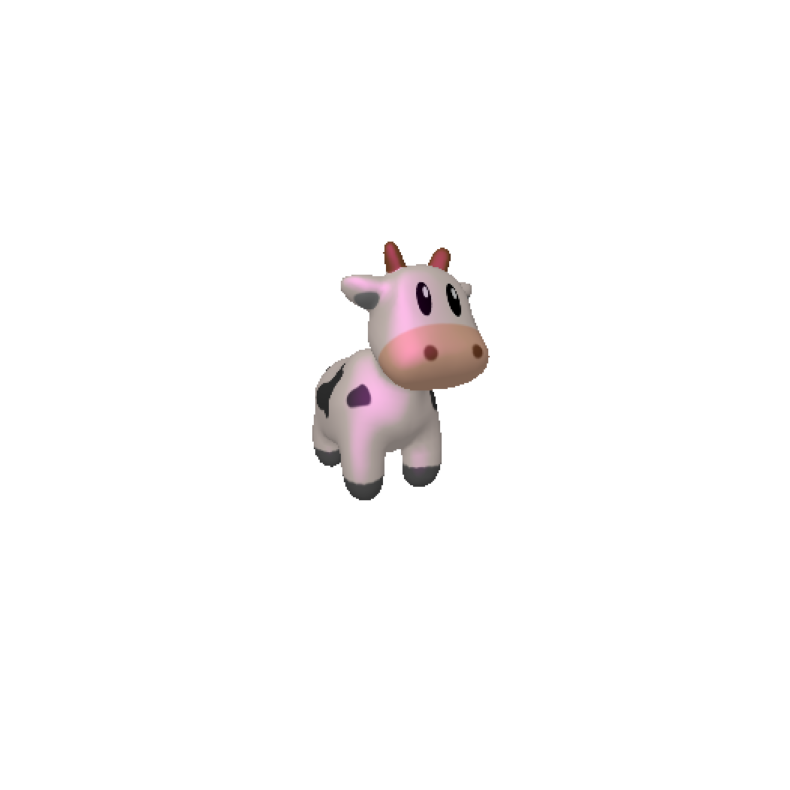

In [60]:
R, T = look_at_view_transform(dist = 2.7, elev = 10, azim = 150)
cameras = PerspectiveCameras(device=device, R=R, T=T)
lights.location = torch.tensor([[2.0, 2.0, -2.0]], device=device)

# изменить блеск с зеркального на фиолет
materials = Materials(
    device=device,
    specular_color = [[1.0, 0.0, 1.0]],
    shininess=1.0
)

# отрисовка
images = renderer(mesh, lights = lights, 
                  materials = materials, cameras=cameras)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis('off')
plt.savefig('morado.png')
plt.show()